In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt

/home/beams/TOMO/conda/anaconda/envs/tomocupy/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 384  # object size n x,y
nz = 384  # object size in z    
ntheta = 4  # number of angles (rotations)

pnz = 384 # tomography chunk size for GPU processing
ptheta = 4 # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 1e-6*2048/n#object voxel size
energy = 33.35  # [keV] xray energy    
focusToDetectorDistance = 128
sx0 = 0.037
z1 = np.array([0.4584,0.4765,0.5488,0.69895])-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1    
norm_magnifications = magnifications/magnifications[0]

print(f'{voxelsize=}')
print(f'{energy=}') 
print(f'{focusToDetectorDistance=}')
print(f'{sx0=}')
print(f'{z1=}')
print(f'{z2=}')
print(f'{distances=}')
print(f'{magnifications=}')    
print(f'normalized magnifications= {norm_magnifications}')
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

voxelsize=5.333333333333333e-06
energy=33.35
focusToDetectorDistance=128
sx0=0.037
z1=array([0.4214 , 0.4395 , 0.5118 , 0.66195])
z2=array([127.5786 , 127.5605 , 127.4882 , 127.33805])
distances=array([0.42001267, 0.43799094, 0.5097536 , 0.65852674])
magnifications=array([303.74940674, 291.24004551, 250.09769441, 193.36807916])
normalized magnifications= [1.         0.95881684 0.8233685  0.63660397]


## Generate phantom

In [3]:
import xraylib
delta_m1 = -2.8e-8#-(1-xraylib.Refractive_Index_Re('Al',energy,2.7)) #density
beta_m1 = 7.2e-9#xraylib.Refractive_Index_Im('Al',energy,2.7)
delta_m2 = -delta_m1#-(1-xraylib.Refractive_Index_Re('H2O',energy,1))
beta_m2 = -beta_m1#xraylib.Refractive_Index_Im('H2O',energy,1)

print(delta_m1,beta_m1)

print(delta_m2,beta_m2)

ellipses = [[delta_m1+1j*beta_m1, 0.4, 0.4, 0.4, 0,0,0,0],
            [delta_m2+1j*beta_m2, 0.35, 0.35, 0.35, 0,0,0,0]]

def phantom (ellipses):
	
    
    # Blank image
    p = np.zeros ((n, n, n),dtype='complex')
    
    # Create the pixel grid
    zgrid, ygrid, xgrid = np.mgrid[-1:1:(1j*n), -1:1:(1j*n), -1:1:(1j*n)]
    
    for ellip in ellipses:
        I   = ellip[0] #
        a2  = ellip [1]**2
        b2  = ellip [2]**2
        b3  = ellip [3]**2
        x0  = ellip [4]
        y0  = ellip [5]
        z0  = ellip [6]
        phi = ellip [7] * np.pi / 180  # Rotation angle in radians
        
        # Create the offset x and y values for the grid
        x = xgrid - x0
        y = ygrid - y0
        z = zgrid - z0
        
        cos_p = np.cos (phi) 
        sin_p = np.sin (phi)
        
        # Find the pixels within the ellipse
        locs = (((x * cos_p + y * sin_p)**2) / a2 
              + ((y * cos_p - x * sin_p)**2) / b2
              + (z**2) / b3)<= 1
        
        # Add the ellipse intensity to those pixels
        p [locs] += I

    return p          

-2.8e-08 7.2e-09
2.8e-08 -7.2e-09


In [4]:
import scipy.ndimage as ndimage

u = phantom(ellipses).astype('complex64')#[nz//2]


# beta0 = dxchange.read_tiff('data/beta-chip-256.tiff')
# delta0 = dxchange.read_tiff('data/delta-chip-256.tiff')
# delta = np.zeros([nz,n,n],dtype='complex64')
# beta = np.zeros([nz,n,n],dtype='complex64')
# delta[nz//2-128:nz//2+128,n//2-128:n//2+128,n//2-128:n//2+128]= delta0
# beta[nz//2-128:nz//2+128,n//2-128:n//2+128,n//2-128:n//2+128]= beta0
# # delta[nz//2-128//2:nz//2+128//2,n//2-128//2:n//2+128//2,n//2-128//2:n//2+128//2]= delta0[::2,::2,::2]
# # beta[nz//2-128//2:nz//2+128//2,n//2-128//2:n//2+128//2,n//2-128//2:n//2+128//2]= beta0[::2,::2,::2]
# delta=(delta<0)*np.mean(delta)
# beta=(beta>0)*np.mean(beta)
# u = delta/20+1j*beta

print(np.min(u.real))
print(np.max(u.imag))
v = np.arange(-n//2,n//2)/n
v = np.exp(-1*v**2)
v = v[np.newaxis,np.newaxis,:]*v[:,np.newaxis,np.newaxis]*v[np.newaxis,:,np.newaxis]
u = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u),axes=(0,1,2)))
u = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(v*u),axes=(0,1,2)))
u = u.astype('complex64')#/np.linalg.norm(v)
u[u.real>0]=0
u[u.imag<0]=0

-2.8e-08
7.2e-09


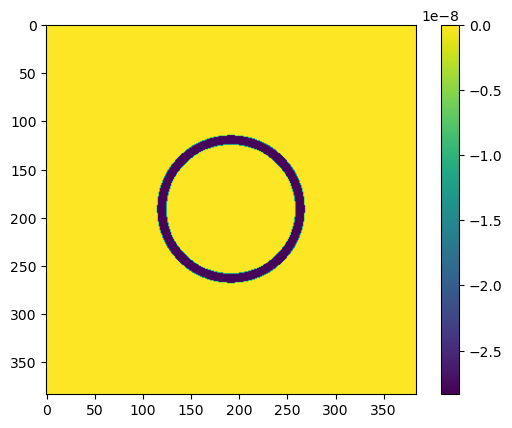

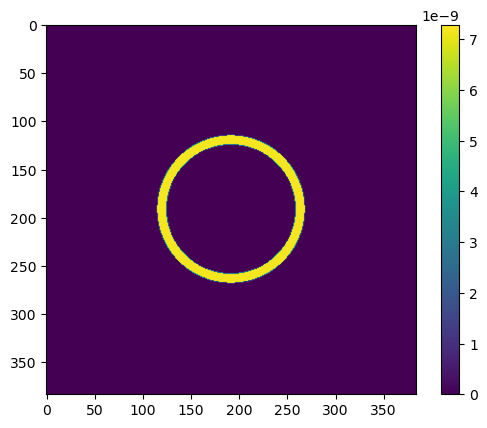

In [5]:
plt.imshow(u[nz//2].real);
plt.colorbar()
plt.show()
plt.imshow(u[nz//2].imag);
plt.colorbar()
plt.show()

Note that in this formation delta is negative

## Create a solver class for tomography

In [6]:
tslv = holotomo.SolverTomo(theta, ntheta, nz, n, pnz, center)

note pnz parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pnz=nz. If the gpu does not have enough memory then pnz should  be decreased

## Create a solver class for holography

In [7]:
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

note pntheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

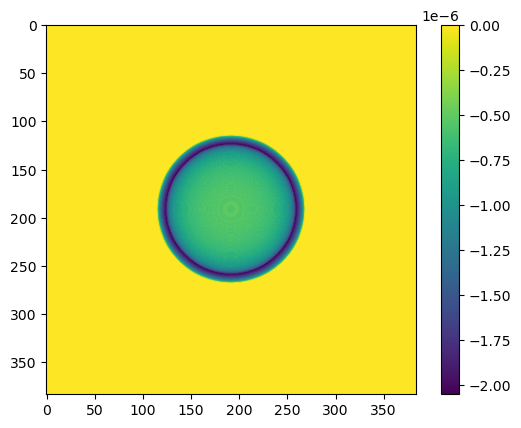

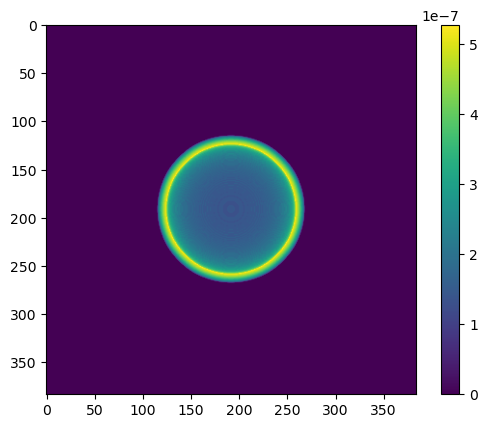

In [8]:
Ru = tslv.fwd_tomo_batch(u)
plt.imshow(Ru[0].real)
plt.colorbar()
plt.show()
plt.imshow(Ru[0].imag)
plt.colorbar()
plt.show()

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [9]:
psi = pslv.exptomo(Ru)

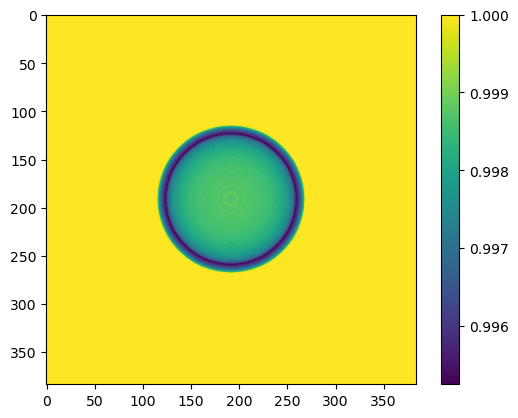

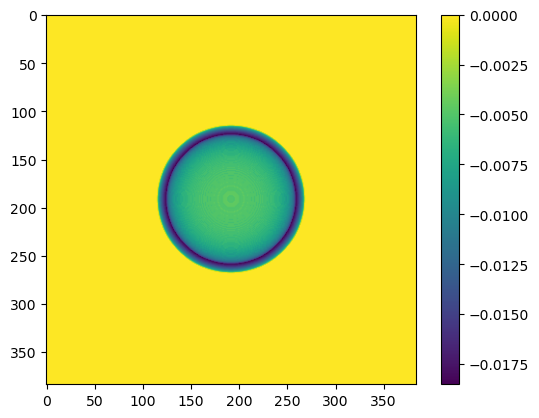

In [10]:
plt.imshow(np.abs(psi[0]))
plt.colorbar()
plt.show()
plt.imshow(np.angle(psi[0]))
plt.colorbar()
plt.show()

## Read reference images (probes) recovered by the NFP (Near-field ptychogarphy) method at ID16A. There are probes for 4 different distances.

In [11]:
prb = np.zeros([len(distances),nz,n],dtype='complex64')    
prb_abs = dxchange.read_tiff_stack('data/prb_id16a/prb_abs_00000.tiff',ind=range(len(distances)))[:,1024-n//2:1024+n//2,1024-n//2:1024+n//2]
prb_phase = dxchange.read_tiff_stack('data/prb_id16a/prb_phase_00000.tiff',ind=range(len(distances)))[:,1024-n//2:1024+n//2,1024-n//2:1024+n//2]
prb[:] = prb_abs*np.exp(1j*prb_phase)            
prb[:] = 1

note the original reference images are 2048x2048, for this tests they are cropped

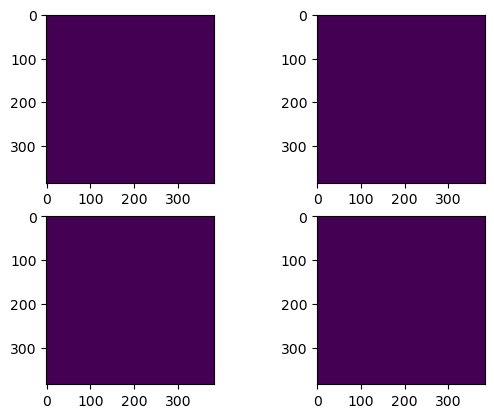

In [12]:
plt.subplot(2,2,1)
plt.imshow(np.abs(prb[0]))
plt.subplot(2,2,2)
plt.imshow(np.angle(prb[0]))
plt.subplot(2,2,3)
plt.imshow(np.abs(prb[-1]))
plt.subplot(2,2,4)
plt.imshow(np.angle(prb[-1]))
plt.show()

# Compute holographic projections for all angles and all distances

In [13]:
fpsi = pslv.fwd_holo_batch(psi,prb)

## Take squared absolute value to simulate data on the detector

In [14]:
data = np.abs(fpsi)**2

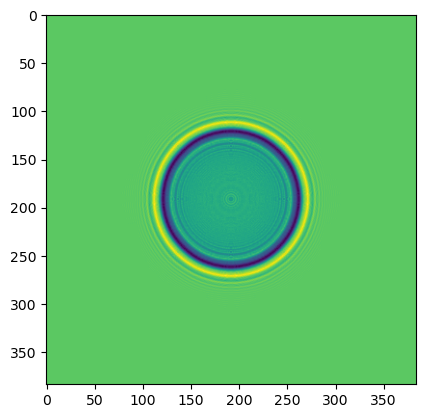

In [15]:
plt.imshow(data[0,0])

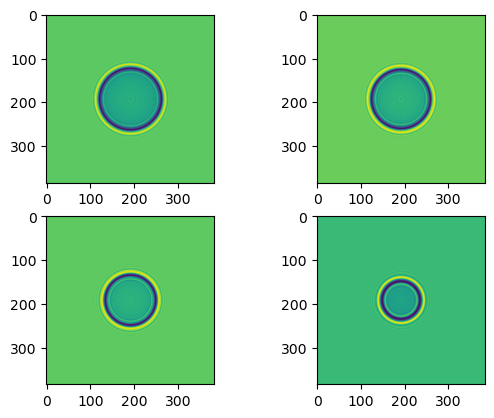

In [16]:
plt.subplot(2,2,1)
plt.imshow(data[0,0])
plt.subplot(2,2,2)
plt.imshow(data[1,0])
plt.subplot(2,2,3)
plt.imshow(data[2,0])
plt.subplot(2,2,4)
plt.imshow(data[3,0])
plt.show()

# Perform the adjoint test to check the correctnes of the adjoint operator for the iterative scheme $<\mathcal{G}^*\mathcal{G}\psi,\psi> = <\mathcal{G}\psi,\mathcal{G}\psi>$

In [17]:
psi0 = pslv.adj_holo_batch(fpsi, prb)

In [18]:
print(f'Adjoint test: {np.sum(psi*np.conj(psi0))} ? {np.sum(fpsi*np.conj(fpsi))}')        

Adjoint test: (2358326.5-0.004033329896628857j) ? (2358326.5+1.5861218116697273e-07j)


# Solving the problem $\sum_{k,j}\||\mathcal{G}_kq_k \psi_j|-d_{k,j}\|_2\to min$ with the Conjugate Gradient

In [19]:
piter = 64 # number of CG iters
init = psi*0+1 # initial guess
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)
rec = pslv.cg_holo_batch(data,init,prb,piter)

Processing angles: [0 1 2 3]
0) gamma=0.5, err=2.462566614151001
1) gamma=0.5, err=0.5532939434051514
2) gamma=0.5, err=0.0666969045996666
3) gamma=0.5, err=0.05500594154000282
4) gamma=0.25, err=0.05242948979139328
5) gamma=0.25, err=0.037333305925130844
6) gamma=0.25, err=0.030016189441084862
7) gamma=0.25, err=0.026544703170657158
8) gamma=0.25, err=0.02463105507194996
9) gamma=0.25, err=0.02133755572140217
10) gamma=0.25, err=0.018928585574030876
11) gamma=0.25, err=0.01696588657796383
12) gamma=0.25, err=0.01483762077987194
13) gamma=0.25, err=0.013346316292881966
14) gamma=0.25, err=0.01226483192294836
15) gamma=0.25, err=0.011462519876658916
16) gamma=0.25, err=0.010687592439353466
17) gamma=0.25, err=0.010023278184235096
18) gamma=0.25, err=0.009452346712350845
19) gamma=0.25, err=0.008764296770095825
20) gamma=0.25, err=0.008182975463569164
21) gamma=0.25, err=0.007632656488567591
22) gamma=0.25, err=0.007169413845986128
23) gamma=0.25, err=0.0067912377417087555
24) gamma=0.25

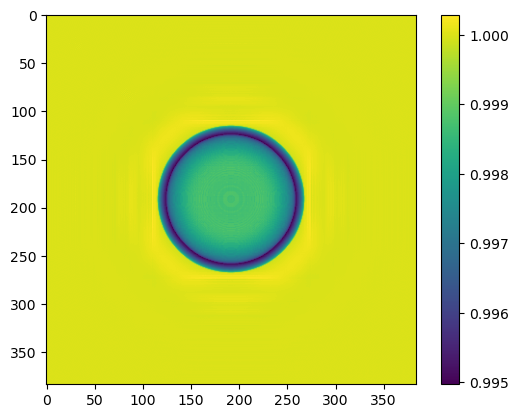

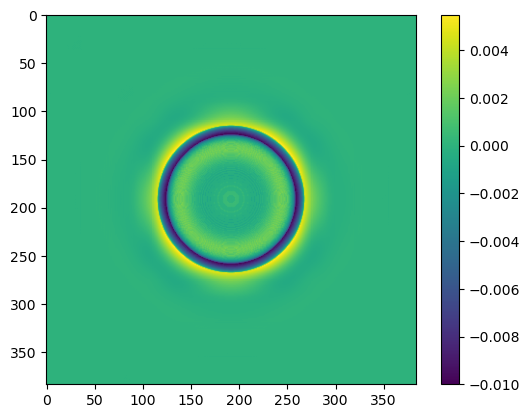

In [20]:
plt.imshow(np.abs(rec[0]))
plt.colorbar()
plt.show()
plt.imshow(np.angle(rec[0]))
plt.colorbar()
plt.show()

# Comparison to the ground truth:

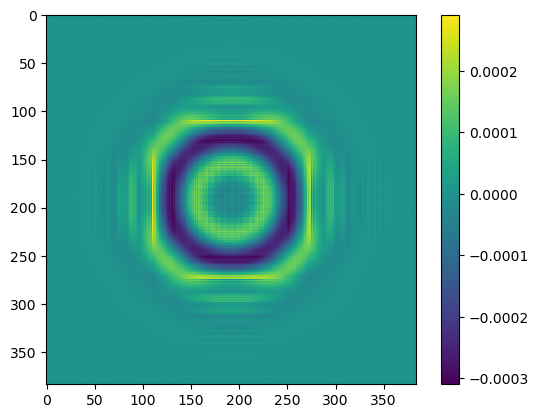

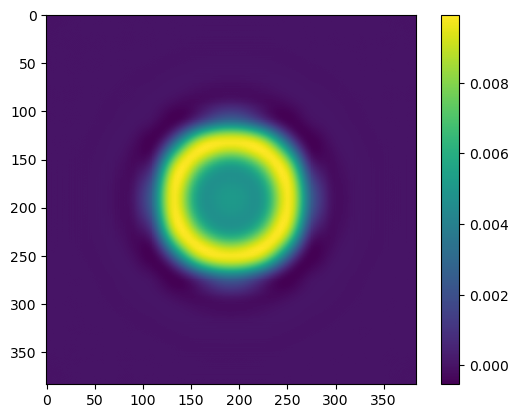

In [21]:
plt.imshow(np.abs(rec[0])-np.abs(psi[0]))
plt.colorbar()
plt.show()
plt.imshow(np.angle(rec[0])-np.angle(psi[0]))
plt.colorbar()
plt.show()

# Convert the recovered transmittance function to the complex refracive index:

In [22]:
projrec = pslv.logtomo(rec)

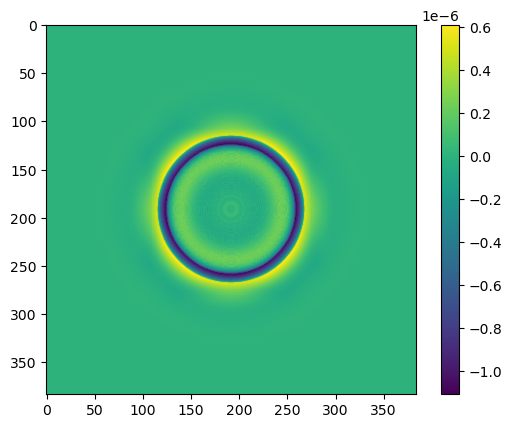

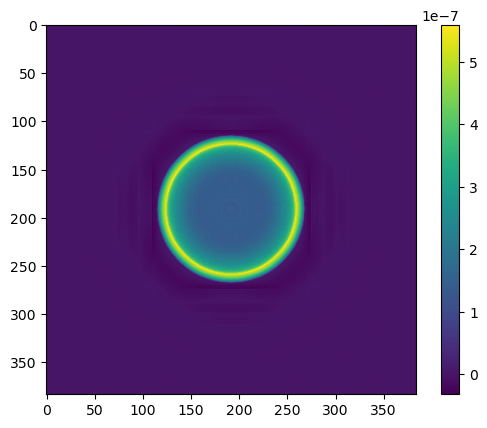

In [23]:
plt.imshow(projrec[0].real)
plt.colorbar()
plt.show()
plt.imshow(projrec[0].imag)
plt.colorbar()
plt.show()

# Solve tomogarphy problem with the Conjugate gradient solver, adding padding data and unpadding reconstruction

In [24]:
ne = n
print(np.linalg.norm(projrec))
with holotomo.SolverTomo(theta, ntheta, nz, ne, pnz, center+(ne-n)/2) as tslv:
    # simulate data
    # projrec = tslv.paddata(projrec, ne)
    # cg solver
    init = np.zeros([nz,ne,ne],dtype='complex64')
    piter = 128
    urec = tslv.cg_tomo_batch(projrec,init,piter)
    # urec = tslv.unpadobject(urec, n)

0.00014066385
Processing slices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 2

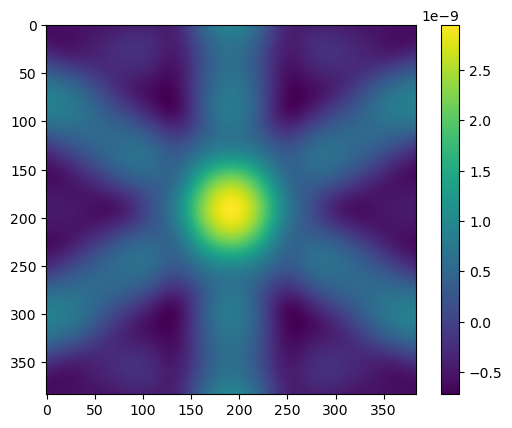

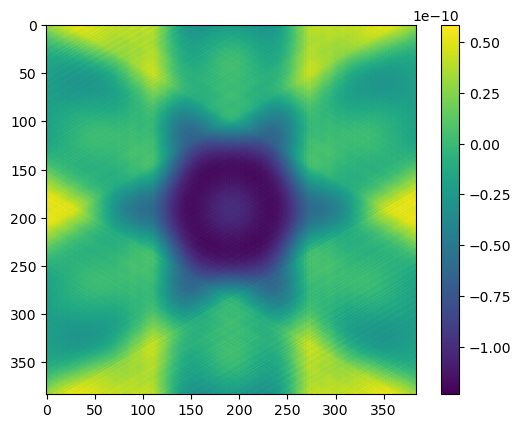

In [25]:
plt.imshow(urec[49+nz//2-256//2].real)
plt.colorbar()
plt.show()
plt.imshow(urec[49+nz//2-256//2].imag)
plt.colorbar()
plt.show()

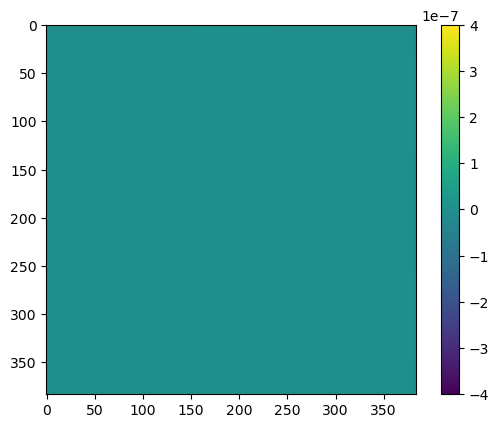

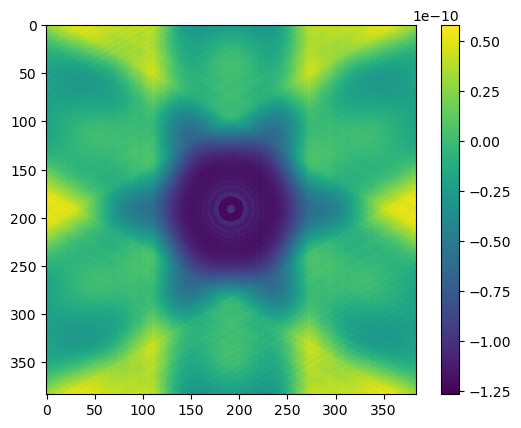

In [26]:
plt.imshow(urec[49+nz//2-256//2].real-u[49+nz//2-256//2].real,vmin=-4e-7,vmax=4e-7)
plt.colorbar()
plt.show()
plt.imshow(urec[49+nz//2-256//2].imag-u[49+nz//2-256//2].imag)
plt.colorbar()
plt.show()